# Report on "Learning Fair Scoring Functions"

- Course: Statistical Theory of Algorithmic Fairness

- Authors: Alexandre Maranhão da Rocha and Ambre Adjevi-Neglokpe

This notebook aims to reproduce step by step the experiment from the paper "Learning Fair Scoring Functions: Bipartite Ranking under ROC-based Fairness Constraints" on the Adult Income dataset. (One additional dataset?)

The notebook is organized around three sections:
1. Loading Data
2. Training the Model
3. Visualizing the Results
4. Running Experiments

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split

from torch import nn
import torch

from tqdm import tqdm

## 1. Loading Data

The Adult Income dataset can be found at https://archive.ics.uci.edu/dataset/2/adult.

In [2]:
!wget https://archive.ics.uci.edu/static/public/2/adult.zip && unzip -o adult.zip

--2024-04-03 22:57:01--  https://archive.ics.uci.edu/static/public/2/adult.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘adult.zip.4’

adult.zip.4             [       <=>          ] 605.70K   489KB/s    in 1.2s    

2024-04-03 22:57:04 (489 KB/s) - ‘adult.zip.4’ saved [620237]

Archive:  adult.zip
  inflating: Index                   
  inflating: adult.data              
  inflating: adult.names             
  inflating: adult.test              
  inflating: old.adult.names         


In [22]:
df_train = pd.read_csv("adult.data", header=None)
columns = ["age", "workclass", "fnlwgt", "education", "education-num",
           "marital-status", "occupation", "relationship", "race", "sex",
           "capital-gain", "capital-loss", "hours-per-week",
           "native-country", "salary"]
df_train.columns = columns
df_test = pd.read_csv("adult.test", header=None, comment="|")
df_test.columns = columns

def proc_z(Z):
    return np.array([1 if "Male" in z else 0 for z in Z])

def proc_y(Y):
    return np.array([1 if ">50K" in y else -1 for y in Y])

Z_train, Z_test = [proc_z(s["sex"]) for s in [df_train, df_test]]
Y_train, Y_test = [proc_y(s["salary"]) for s in [df_train, df_test]]

col_quanti = ["age", "education-num", "capital-gain",
              "capital-loss", "hours-per-week"]  # "fnlwgt",
col_quali = ["workclass", "education", "marital-status", "occupation",
             "relationship", "race", "sex", "native-country"]

X_train_quali = df_train[col_quali].values
X_test_quali = df_test[col_quali].values

X_train_quanti = df_train[col_quanti]
X_test_quanti = df_test[col_quanti]

quali_encoder = OneHotEncoder(categories="auto")  # drop="first")
quali_encoder.fit(X_train_quali)

X_train_quali_enc = quali_encoder.transform(X_train_quali).toarray()
X_test_quali_enc = quali_encoder.transform(X_test_quali).toarray()

X_train = np.concatenate([X_train_quali_enc, X_train_quanti], axis=1)
X_test = np.concatenate([X_test_quali_enc, X_test_quanti], axis=1)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [4]:
!wget https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores.csv

--2024-04-03 22:57:04--  https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3554605 (3.4M) [text/plain]
Saving to: ‘compas-scores.csv.4’

compas-scores.csv.4 100%[===================>]   3.39M  13.4MB/s    in 0.3s    

2024-04-03 22:57:05 (13.4 MB/s) - ‘compas-scores.csv.4’ saved [3554605/3554605]



In [5]:
df_raw = pd.read_csv('compas-scores.csv')
df_raw.loc[0]
df = df_raw[[
    'sex', 'age', 'race',
    'juv_fel_count', 'decile_score', 'juv_misd_count', 'juv_other_count', 'priors_count',
    'days_b_screening_arrest', 'c_jail_in', 'c_jail_out',
    'c_charge_degree','is_recid','v_decile_score',   'decile_score.1'
    ]]

# Filters applied by the paper
df = df[(df["days_b_screening_arrest"] >= -30 ) & (df["days_b_screening_arrest"] <= 30)]
df = df[df["is_recid"] >= 0]
df = df[df["c_charge_degree"] != "O"]

# Boolean sensitive variable: is african-american
Z = (df.race == 'African-American').to_numpy().astype(int)
Y = 2*df["is_recid"].values - 1

# Preprocessing
df["days_in_jail"] = (pd.to_datetime(df["c_jail_out"]) - pd.to_datetime(df["c_jail_in"])).dt.days
df = df.drop(columns=["c_jail_out", "c_jail_in", "days_b_screening_arrest"]) 

col_quanti = ["age", "juv_fel_count", "decile_score", "juv_misd_count",
              "priors_count", "v_decile_score", "decile_score.1",
              "days_in_jail"]
col_quali = ["race", "c_charge_degree"]

X_quali = df[col_quali].values
X_quanti = df[col_quanti].values

# One-Hot Encode Quantitative Features
quali_encoder = OneHotEncoder(categories="auto")
quali_encoder.fit(X_quali)
X_quali = quali_encoder.transform(X_quali).toarray()

X = np.concatenate([X_quanti, X_quali], axis=1)
X_train, X_test, Y_train, Y_test, Z_train, Z_test = train_test_split(
    X, Y, Z, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Now we have in hands our framework with $(X, Y, Z)$.

## 2. Training the Model

The model proposed by the paper is a Multilayer Perceptron (MLP) with three hidden layers and a final batch normalization. All layers have $d$ neurons, where $d$ is the dimension of the input, except for the last one, that has only one output.

In [38]:
class Model(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.fc1 = nn.Linear(n_features, n_features)
        self.fc2 = nn.Linear(n_features, n_features)
        self.fc_out = nn.Linear(n_features, 1)
        self.relu = nn.ReLU()
#         self.bn = nn.BatchNorm1d(1)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc_out(x)    
#         x = self.bn(x)
        return x

The following functions are helpers for the training process.

In [56]:
def incomplete_auc(sc, y, B=100):
    rel = nn.Sigmoid()
    
    p_sc, p_y = sc[y == 1], y[y == 1]
    n_sc, n_y = sc[y != 1], y[y != 1]

    num_n = n_y.size(0)
    num_p = p_y.size(0)

    if num_n == 0 or num_p == 0:
#         assert(False)
        return torch.tensor([0], dtype=float, requires_grad=True), torch.tensor([0],  dtype=float, requires_grad=True)

    # Samples D_B
    n_ind = torch.randint(0, num_n, (B,))
    p_ind = torch.randint(0, num_p, (B,))

    # Takes (s(xi) - s(xj))(1 - (-1))
    prod = 2 * (p_sc[p_ind] - n_sc[n_ind])
    rel_auc = torch.mean(rel(-prod))
    auc = (torch.mean((prod < 0).float()) + 0.5 * torch.mean((prod == 0).float()))
    return rel_auc, auc

    
def gen_batch(X, y, z, dataset_name=None, n_batch=-1, balanced=False):
    if n_batch == -1:
        return X, y, z
    selected = np.random.randint(0, len(y), n_batch)
    
    X_batch = torch.tensor(X[selected, :])
    y_batch = torch.tensor(y[selected])
    z_batch = torch.tensor(z[selected])
    
    return X_batch, y_batch,z_batch 

In [57]:
class AUCLoss():
    def __init__(self, coef_lagrange, adapt_step):
        self.c = 0
        self.coef_lagrange = coef_lagrange
        self.adapt_step = adapt_step
        
        self.history_rel_auc = []
        self.history_fairness = []

    def _compute(self, score, y, z, B):
        rel_auc, auc = incomplete_auc(score, y, B)
        rel_auc_0, auc_0 = incomplete_auc(score[z == 0], y[z == 0], B)
        rel_auc_1, auc_1 = incomplete_auc(score[z == 1], y[z == 1], B)

        rel_fair_auc = rel_auc_0 - rel_auc_1
        fair_auc = auc_0 - auc_1

        rel_cost = rel_auc + self.coef_lagrange*self.c*rel_fair_auc

        cost = auc + self.coef_lagrange*fair_auc
        return rel_cost, rel_auc, fair_auc
        
    def compute(self, score, y, z, B=100):
        rel_cost, rel_auc, fair_auc = self._compute(score, y, z, B)

        self.history_rel_auc.append(rel_auc.item())
        self.history_fairness.append((self.coef_lagrange*self.c*fair_auc).item())
        
        return rel_cost
    
    def update(self, score_val, X_val, y_val, z_val):
        _, _, val_fair_auc = self._compute(score_val, torch.tensor(y_val), torch.tensor(z_val), B=100000)
        self.c = float(min(1, max(-1, self.c + np.sign(val_fair_auc.detach().numpy())*self.adapt_step)))

In [58]:
class ROCLoss():
    def __init__(self, coef_lagrange, adapt_step_c, adapt_step_t, points=None):
        self.adapt_step_c = adapt_step_c
        self.adapt_step_t = adapt_step_t
        if points is None:
            points = {-1: [0.125, 0.25]}
        self.points = points
        self.n_c = sum(len(x) for x in points.values())        
        self.c = [0] * self.n_c
        self.coefs_lagrange = [coef_lagrange] * self.n_c
        self.thresholds = np.array([float(v) for v in self.c])

        
    def _compute(self, score, y, z, B=100):
        rel = nn.Sigmoid()
        rel_auc, auc = incomplete_auc(score, y, B)
        
        rel_pointwise_val = [ ]
        pointwise_val = [ ]
        fprs = [ ]
        tprs = [ ]
        for y_val, points in self.points.items():
            z_sel = z[y == y_val]
            scores_sel = z[y==y_val]
            for ix, pt in enumerate(points):
                # asymmetric cost value
                biased_sc = scores_sel - self.thresholds[ix]

                # Check whether the batch has any samples from Z=0 or Z=1
                n_z_1 = (z == 1).sum()
                no_z_1 = n_z_1 == 0
                no_z_0 = ((z == 1).shape[0] - n_z_1 == 0)

                rel_tpr = torch.mean(rel(biased_sc)[z_sel==1]) if not no_z_1.item() else torch.tensor(0.)
                rel_fpr = torch.mean(rel(biased_sc)[z_sel==0]) if not no_z_0.item() else torch.tensor(0.)

                tpr = (biased_sc[z_sel==1] > 0).float() if not no_z_1.item() else torch.tensor(0.)
                fpr = (biased_sc[z_sel==0] > 0).float() if not no_z_0.item() else torch.tensor(0.)

                # The cost is fpr - tpr
                rel_cost = self.c[ix]*(rel_fpr - rel_tpr)
                cost = self.c[ix]*(fpr.mean() - tpr.mean())

                rel_pointwise_val.append(rel_cost)
                pointwise_val.append(cost)
                tprs.append(tpr.mean())
                fprs.append(fpr.mean())
                
        
        rel_cost = rel_auc 
        cost = auc 
        for i in range(self.n_c):
            if self.coefs_lagrange[i] > 0:
                rel_cost += self.coefs_lagrange[i]*rel_pointwise_val[i]
                cost += self.coefs_lagrange[i]*pointwise_val[i]
                
        return rel_cost, (np.array(fprs), np.array(tprs))
    
    def compute(self, score, y, z, B=100):
        rel_cost, _ = self._compute(score, y, z, B=100)
        return rel_cost
        
    def update(self, score_val, X_val, y_val, z_val):
        _, (fprs,tprs) = self._compute(score_val, torch.tensor(y_val), torch.tensor(z_val), B=100000)
        mon_vals = np.array(list(itertools.chain.from_iterable(self.points.values())))
        devs = (fprs - tprs)/2
        means = (fprs + tprs)/2
        for i in range(self.n_c):
            if np.abs(means[i] - mon_vals[i]) > np.abs(devs[i]):
                # Change the threshold
                if means[i] > mon_vals[i]:
                    self.thre[i] = self.thre[i] + self.adapt_step_t
                else:
                    self.thre[i] = self.thre[i] - self.adapt_step_t
            else:
                if devs[i] > 0:
                    self.c[i] = min(self.c[i] + self.adapt_step_c, 1)
                else:
                    self.c[i] = max(self.c[i] - self.adapt_step_c, -1)

We further split the training data between training and validation.

In [59]:
import matplotlib.pyplot as plt
import itertools

def train_model(loss_calculator):
    n_iter = 20000
    coef_regularization = 0.05
    display_step = 50
    batch_size = 100

    n_features = X_train.shape[1]

    model = Model(n_features)

    X_tr, X_val, y_tr, y_val, z_tr, z_val = train_test_split(X_train, Y_train, Z_train, test_size=0.4, random_state=42)
#     while (y_val != 1).sum() == 0 or (y_val == 1).sum() ==0:
#         X_tr, X_val, y_tr, y_val, z_tr, z_val = train_test_split(X_train, Y_train, Z_train, test_size=0.4, random_state=42)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    # Training Loop
    history = []
    for step in tqdm(range(n_iter)):
        X_batch, y_batch, z_batch = gen_batch(X_tr, y_tr, z_tr, n_batch=batch_size, balanced=False)

        score_batch = model(X_batch.float())

        loss = loss_calculator.compute(score_batch, y_batch, z_batch, B=batch_size)
        reg_loss = 0
        for param in model.parameters():
            loss += coef_regularization * 0.5 * param.norm(2)**2
            reg_loss += coef_regularization * 0.5 * param.norm(2)**2

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()  

        history.append(loss.item())

        if (step == n_iter - 1) or (step % display_step == 0):
            with torch.no_grad():
                score_val = model(torch.tensor(X_val).float())
            loss_calculator.update(score_val, X_val, y_val, z_val)

    return model, history

In [ ]:
unconstrained_loss = AUCLoss(coef_lagrange=0, adapt_step=0.01)
model_noconstraint, history = train_model(loss_calculator=unconstrained_loss)

cumsum_vec = np.cumsum(np.insert(history, 0, 0)) 
window_width = 1000
ma_vec = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width
plt.plot(ma_vec)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

  1%|          | 186/20000 [00:02<05:12, 63.50it/s]


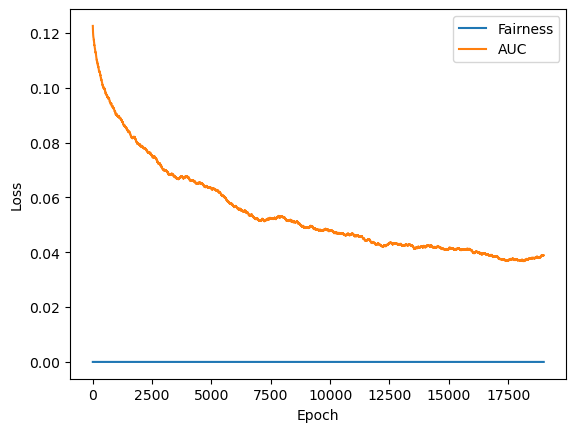

In [24]:
def ma(x, window_width = 1000):
    cumsum_vec = np.cumsum(np.insert(x, 0, 0)) 
    ma_vec = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width
    return ma_vec

plt.plot(ma(unconstrained_loss.history_fairness), label='Fairness')
plt.plot(ma(unconstrained_loss.history_rel_auc), label='AUC')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [25]:
aucloss = AUCLoss(coef_lagrange=1, adapt_step=0.01)
model_auc, history = train_model(loss_calculator=aucloss)

100%|██████████| 20000/20000 [00:55<00:00, 361.79it/s]


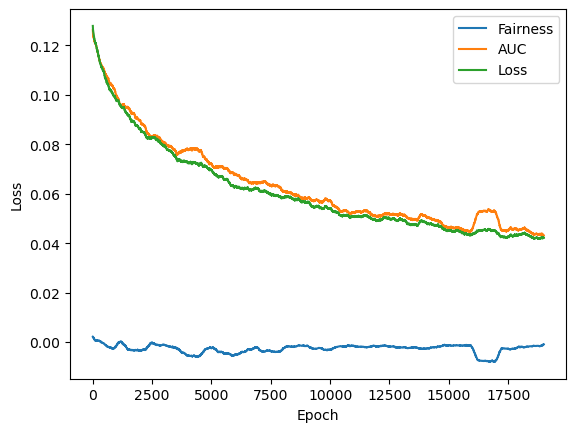

In [26]:
def ma(x, window_width = 1000):
    cumsum_vec = np.cumsum(np.insert(x, 0, 0)) 
    ma_vec = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width
    return ma_vec

plt.plot(ma(aucloss.history_fairness), label='Fairness')
plt.plot(ma(aucloss.history_rel_auc), label='AUC')
plt.plot(ma(history), label='Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

100%|██████████| 20000/20000 [00:53<00:00, 375.34it/s]


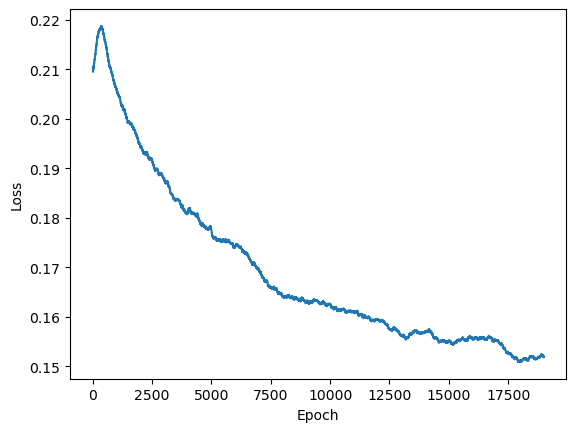

In [27]:
rocloss = ROCLoss(coef_lagrange=0.25, adapt_step_t=0.01, adapt_step_c=0.1)
model_roc, history = train_model(loss_calculator=rocloss)

plt.plot(ma(history))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## 3. Evaluation

First, we use the trained model to calculate the scores in the test set. Then, we can calculate the False Positive and True Positive rates to plot the ROC curves. 

In [28]:
def fpr_tpr(scores, classes):
    scores = np.array(scores)
    classes = (np.array(classes) == +1).astype(int)

    n_pos = classes.sum()
    n_neg = classes.shape[0] - n_pos

    # indices of scores in increasing order
    ind_sort = np.argsort(scores)
    # if the scoring is perfect, all 0 would come before all 1s
    cl_sort = classes[ind_sort]
    
    # False Negative Rate (FN/(TP+FN))
    # False Negatives are all 1s that came before the threshold
    # TP+FN are all samples that have a positive real label
    fnr = cl_sort.cumsum()/n_pos
    # True Positive Rate (TP/(TP+FN))
    tpr = 1 - fnr
    # True Negative Rate (TN/(FP+TN))
    # True Negatives are all 0s that came before the threshold
    # FP+TN are all samples that have a negative real label
    tnr = (1-cl_sort).cumsum()/n_neg
    # False Positive Rate (FP/(FP+TN))
    fpr = 1 - tnr

    return fpr, tpr

def auc(scores, classes, B=None):
    if B is None:
        s = scores.reshape((-1, 1))
        y = classes.reshape((-1, 1))
        ind_0, ind_1 = np.where((y-y.transpose()) > 0)
        delta_s = s[ind_0] - s[ind_1]
    else:
        s = scores
        y = classes
        f_p = (y == 1)
        s_p, s_n = s[f_p], s[~f_p]
        delta_s = np.random.choice(s_p, B) - np.random.choice(s_n, B)
    return (delta_s > 0).mean() + 0.5*(delta_s == 0).mean()


In [29]:
def plot_evaluation(s_test, Y_test, Z_test):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    s_1 = "$ROC_{H_s^{(0)}, G_s^{(0)}}$"
    s_2 = "$ROC_{H_s^{(1)}, G_s^{(1)}}$"

    fpr_1, tpr_1 = fpr_tpr(s_test[Z_test==0], Y_test[Z_test==0])
    fpr_2, tpr_2 = fpr_tpr(s_test[Z_test==1], Y_test[Z_test==1])
    fpr, tpr = fpr_tpr(s_test, Y_test)

    axs[0].plot(fpr_1, tpr_1, label=s_1, color="green", linestyle='-')
    axs[0].plot(fpr_2, tpr_2, label=s_2, color="blue", linestyle='-')
    axs[0].plot(fpr, tpr, label="$ROC_{H_s, G_s}$", color="black", linestyle='-')

    s_1, s_2 = "$ROC_{H_s^{(0)}, H_s^{(1)}}$", "$ROC_{G_s^{(0)}, G_s^{(1)}}$"

    fpr_1, tpr_1 = fpr_tpr(s_test[Y_test!=1], Z_test[Y_test!=1])
    fpr_2, tpr_2 = fpr_tpr(s_test[Y_test==1], Z_test[Y_test==1])
    fpr, tpr = fpr_tpr(s_test, Y_test)

    axs[1].plot([0, 1], [0, 1], color="grey")
    axs[1].plot(fpr_1, tpr_1, label=s_1, color="green", linestyle='-')
    axs[1].plot(fpr_2, tpr_2, label=s_2, color="blue", linestyle='-')

    for ax in axs:
        ax.set_xlabel("$FPR$")
        ax.set_ylabel("$TPR$")
        ax.grid()
        ax.legend()

    plt.tight_layout()

Now we can conduct the whole process for three different models:

1. No constraint
2. AUC contraint
3. ROC constraint

Test AUC: 89.96%
Violation: -3.81%


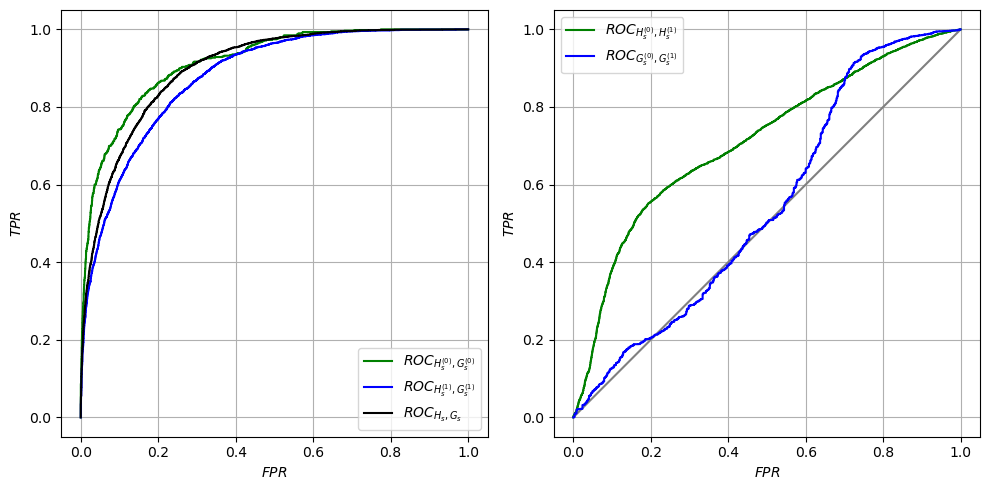

In [37]:
# 1. No constraint
s_test_noconstraint = model_noconstraint(torch.tensor(X_test).float()).detach().numpy().ravel().astype(float)
print(f'Test AUC: {auc(s_test_noconstraint, Y_test):.2%}')
auc_violation = auc(s_test_noconstraint[Z_test==1], Y_test[Z_test==1])-auc(s_test_noconstraint[Z_test==0], Y_test[Z_test==0])
print(f'Violation: {auc_violation:.2%}')
plot_evaluation(s_test_noconstraint, Y_test, Z_test)

Test AUC: 86.59%
Violation: -2.86%


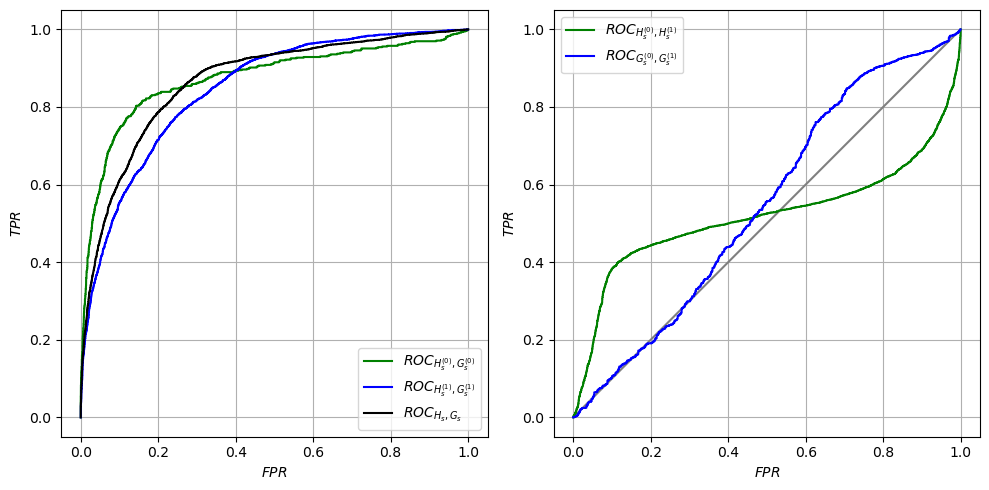

In [31]:
# 2. AUC constraint
s_test_auc = model_auc(torch.tensor(X_test).float()).detach().numpy().ravel().astype(float)
print(f'Test AUC: {auc(s_test_auc, Y_test):.2%}')
auc_violation = auc(s_test_auc[Z_test==1], Y_test[Z_test==1])-auc(s_test_auc[Z_test==0], Y_test[Z_test==0])
print(f'Violation: {auc_violation:.2%}')
plot_evaluation(s_test_auc, Y_test, Z_test)

Test AUC: 86.77%
Violation: -2.84%


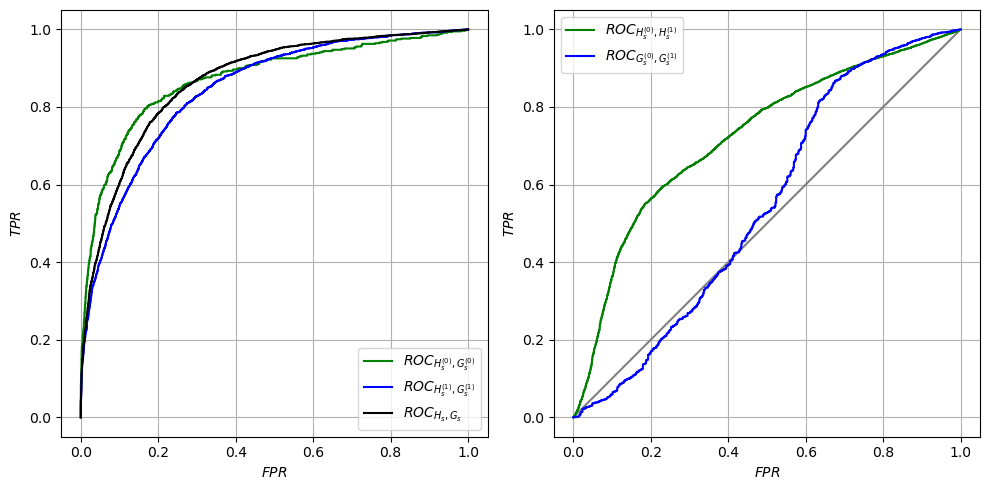

In [34]:
# 3. ROC constraint
s_test_roc = model_roc(torch.tensor(X_test).float()).detach().numpy().ravel().astype(float)
print(f'Test AUC: {auc(s_test_roc, Y_test):.2%}')
auc_violation = auc(s_test_roc[Z_test==1], Y_test[Z_test==1])-auc(s_test_roc[Z_test==0], Y_test[Z_test==0])
print(f'Violation: {auc_violation:.2%}')
plot_evaluation(s_test_roc, Y_test, Z_test)